In [2]:
import numpy as np 
import pandas as pd
import networkx as nx
import matplotlib as plt 
import markov_clustering as mc
import random
import csv
import matplotlib.pyplot as plt
%matplotlib inline
from itertools import combinations
from scipy.stats import describe
from collections import Counter

In [3]:
def count_by(df,var):
    nb = df.groupby([var],group_keys=False).size()
    nb = pd.DataFrame({var:nb.index,'nb_'+var:nb.values})
    nb = pd.merge(df,nb,on=var,how='left')
    return nb

In [31]:
%run rome.py
romes = list(graph.keys())

<Figure size 432x288 with 0 Axes>

In [32]:
data = pd.read_csv("../bases/rome_tension.csv")

In [33]:
data = data[['rome5','BE_id','T']]
data = data.pivot(index='BE_id',columns='rome5',values='T')

Define undirected graph

In [34]:
G = nx.Graph()
G.add_nodes_from(romes)
weights = {}
R = 1
for rome1 in romes:
    weights[rome1] = {}
    s = 0
    for rome2 in graph[rome1]:
        corr = np.float_power(data[rome1].corr(data[rome2]),R)
        if corr > 0: # replace by rome1[0] = rome2[0]
            weights[rome1][rome2] = corr
            s += weights[rome1][rome2]
    for rome2 in weights[rome1].keys():
        weights[rome1][rome2] =  weights[rome1][rome2]/s

for rome1 in romes:
    current_edges = list(G.edges)
    for rome2 in weights[rome1].keys():
        if rome1 not in weights[rome2].keys(): w = weights[rome1][rome2]/2
        if rome1 in weights[rome2].keys(): w = (weights[rome1][rome2]+weights[rome2][rome1])/2
        if (rome2,rome1) not in current_edges:
                G.add_edge(rome1,rome2,weight=w)
                
matrix = nx.adjacency_matrix(G)

**Run MCL algorithm for different inflation parameters:** 

In [35]:
inflations = [round(1.1 + i/10,ndigits=1) for i in range(10)]
results = {'clusters':{},
           'lonely':{},
           'mean_size':{},
           'median_size':{},
           'average_within':{},
           'average_shortest_path':{}}
clustered_romes = pd.DataFrame()
clustered_romes['rome'] = romes
store_CL = {}
for inf in inflations:
    result = mc.run_mcl(matrix,inflation=inf)
    clusters = mc.get_clusters(result)
    CL = [[romes[x] for x in c] for c in clusters]
    store_CL[inf] = CL 
    results['clusters'][inf] = len(CL)
    results['lonely'][inf] = sum([len(cl) == 1 for cl in CL])
    results['mean_size'][inf] = np.mean([len(c) for c in CL])
    results['median_size'][inf] = np.median([len(c) for c in CL])
    results['average_within'][inf] = 0
    results['average_shortest_path'][inf] = 0
    
    clusters = []
    groups = []
    shortest = []
    
    s = 0
    for i, clus in enumerate(CL):
        clusters += clus
        groups += [i+1]*len(clus)
        s += len(clus)
        results['average_within'][inf] += data.filter(clus).mean().values.var()/(results['clusters'][inf]-results['lonely'][inf])
        n = 0
        p = 0
        for c in combinations(clus,2):
            p += nx.shortest_path_length(G,c[0],c[1])
            n += 1
        if n > 0: 
            shortest +=  [p/n]*len(clus)
            results['average_shortest_path'][inf] += (p/n)*len(clus)/len(romes)
        else : shortest +=  [0]*len(clus)
    tmp = pd.DataFrame()
    tmp['rome'] = clusters
    tmp[f'group_{inf}'] = groups
    tmp[f'shortest_{inf}'] = shortest
    tmp = tmp.sort_values('rome')
    clustered_romes = pd.merge(clustered_romes,tmp,on='rome',how='right')
    for key in ['mean_size','median_size','average_shortest_path']:
        results[key][inf] = round(results[key][inf],ndigits=1)
    results['average_within'][inf] = round(results['average_within'][inf],ndigits = 4)
    

In [36]:
pd.DataFrame(results).to_latex('../results/mcl_results.tex')

Select $\pi$ = 1.5

In [38]:
clustered_romes = clustered_romes.filter(['rome','group_1.5','shortest_1.5'])
clustered_romes.columns = 'rome', 'group','shortest'

Load rome labels

In [39]:
tree = pd.read_csv("../bases/fap_pcs_rome.csv")
tree.columns = 'fap','fap_lab','pcs','pcs_lab','rome','qual','rome_lab'
tree = tree.filter(items=['fap','fap_lab','rome','rome_lab'])
tree['fap']= tree['fap'].fillna(method='ffill')
tree['fap_lab']= tree['fap_lab'].fillna(method='ffill')
tree = tree.dropna(subset=['rome'],axis=0)
tree = count_by(tree,'rome')
arbo = tree.filter(['rome','rome_lab'])
arbo = arbo.drop_duplicates('rome')

Merge results to labels

In [40]:
clustered_romes = pd.merge(clustered_romes,arbo,on='rome',how='left')

In [41]:
clustered_romes.loc[clustered_romes.rome == 'L1510','rome_lab'] = "Films d'animation et effets spéciaux"
clustered_romes = clustered_romes.sort_values('group').reset_index(drop=True)

In [42]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(clustered_romes)

      rome  group  shortest                                           rome_lab
0    E1106      1  1.800000                   Journalisme et information média
1    E1107      1  1.800000                        Organisation d'événementiel
2    E1103      1  1.800000                                      Communication
3    E1108      1  1.800000                         Traduction, interprétariat
4    E1401      1  1.800000            Développement et promotion publicitaire
5    E1104      2  1.666667                 Conception de contenus multimédias
6    E1205      2  1.666667                Réalisation de contenus multimédias
7    E1306      2  1.666667                                          Prépresse
8    M1805      2  1.666667               Études et développement informatique
9    E1105      3  1.000000                             Coordination d'édition
10   E1305      3  1.000000     Préparation et correction en édition et presse
11   L1304      4  1.333333     Réalisation cinémato

In [43]:
clustered_romes = clustered_romes.filter(['rome','group','rome_lab','shortest'])
clustered_romes.to_csv('../results/clustered_romes_1_5.csv',index=False)

**Purge graph from romes that are within a same group:**

In [44]:
clusters = clustered_romes.group.unique().tolist()
cluster_groups = {i+1:clustered_romes.loc[clustered_romes.group == clus, 'rome'].tolist() for i, clus in enumerate(clusters)}


In [45]:
clustered_graph = {}
for i,group in cluster_groups.items(): 
    clustered_graph[i] = []
    for rome in group:
        clustered_graph[i] += [j for j, clus in cluster_groups.items() if list(set(clus) & set(graph[rome])) != [] and j != i ]
    clustered_graph[i] = list(set(clustered_graph[i]))

In [46]:
purged_graph = {}
for rome, romes in graph.items():
    g = clustered_romes.loc[clustered_romes.rome == rome,'group'].values.tolist()[0]
    group = clustered_romes.loc[clustered_romes.group == g,'rome'].values.tolist()
    purged_graph[rome] = [x for x in romes if x not in group]

In [23]:
np.std([len(connex) for connex in graph.values()])

2.3172559986371986

In [24]:
np.mean([len(connex) for connex in purged_graph.values()])

2.231203007518797

In [25]:
np.mean([len(connex) for connex in clustered_graph.values()])

4.264423076923077

In [26]:
graph_lengths = Counter([len(connex) for connex in graph.values()])
purged_graph_lengths = Counter([len(connex) for connex in purged_graph.values()])
clustered_graph_lengths = Counter([len(connex) for connex in clustered_graph.values()])

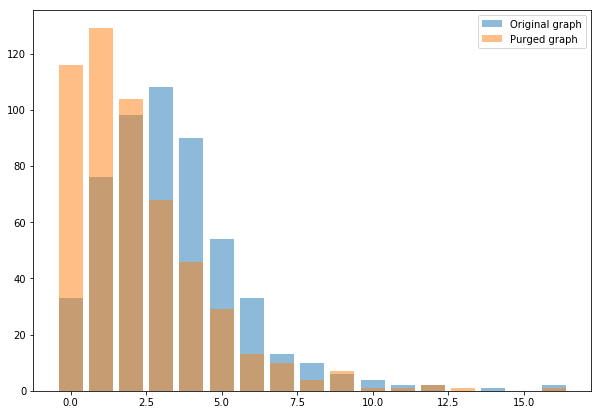

In [27]:
fig, axs = plt.subplots(sharex=True,figsize=(10,7))
axs.bar(graph_lengths.keys(),graph_lengths.values(),alpha=0.5)
axs.bar(purged_graph_lengths.keys(),purged_graph_lengths.values(),alpha=0.5)
axs.legend(['Original graph','Purged graph'])
fig.savefig('../results/connex_romes.png')

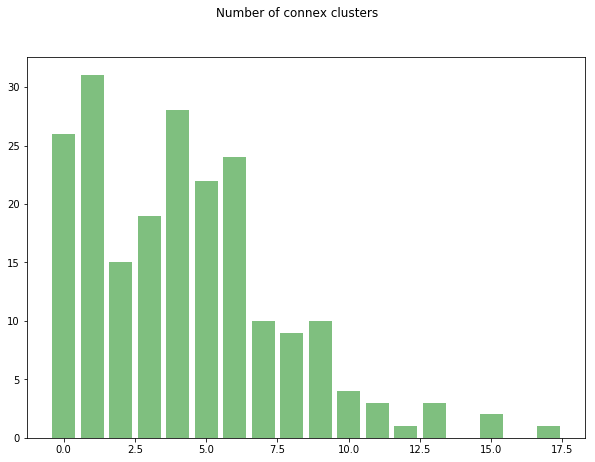

In [28]:
fig, ax = plt.subplots(sharex=True,figsize=(10,7))
fig.suptitle('Number of connex clusters')
ax.bar(clustered_graph_lengths.keys(),clustered_graph_lengths.values(),color='g',alpha=0.5)
fig.savefig('../results/connex_clusters.png')